In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install torch torchvision --quiet
!pip install matplotlib requests --quiet


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
LABELS = [
    'Atelectasis',
    'Cardiomegaly',
    'Consolidation',
    'Edema',
    'Effusion',
    'Emphysema',
    'Fibrosis',
    'Hernia',
    'Infiltration',
    'Mass',
    'No Finding',
    'Nodule',
    'Pleural_Thickening',
    'Pneumonia',
    'Pneumothorax'
]

N_CLASSES = len(LABELS)
print("Number of classes:", N_CLASSES)
print("Labels:", LABELS)


Number of classes: 15
Labels: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [ ]:
def load_trained_resnet(checkpoint_path):
    # Start from ImageNet pretrained ResNet50
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = resnet50(weights=weights)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, N_CLASSES)

    state_dict = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state_dict)

    model = model.to(device)
    model.eval()
    return model

checkpoint_path = "/content/drive/Shareddrives/STA_160/nih_resnet50_finetuned_best.pth"
resnet_model = load_trained_resnet(checkpoint_path)
print("Loaded trained model from:", checkpoint_path)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 77.7MB/s]


Loaded trained model from: /content/drive/Shareddrives/STA_160/nih_resnet50_finetuned_best.pth


In [ ]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),                          # [1, H, W] in [0,1]
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)), # [3, H, W]
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],                 # ImageNet stats
        std=[0.229, 0.224, 0.225]
    )
])


In [ ]:
def predict_xray_from_url(url, top_k=10, show_image=True):
    print("Downloading:", url)
    resp = requests.get(url)
    resp.raise_for_status()

    # Open as grayscale
    img = Image.open(BytesIO(resp.content)).convert("L")

    if show_image:
        plt.imshow(img, cmap="gray")
        plt.title("Input chest X-ray from URL")
        plt.axis("off")
        plt.show()

    # Preprocess
    x = preprocess(img).unsqueeze(0).to(device)  # [1, 3, 224, 224]

    # Inference
    resnet_model.eval()
    with torch.no_grad():
        logits = resnet_model(x)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    # Sort by probability
    pairs = list(zip(LABELS, probs))
    pairs.sort(key=lambda t: t[1], reverse=True)

    print("\nTop predicted labels:")
    for label, p in pairs[:top_k]:
        print(f"{label:20s}  {p:.3f}")

    return pairs


Downloading: https://prod-images-static.radiopaedia.org/images/10136416/502185e27fd4aadd6f1bcc65dd5738d4ed8da4aaec6e901cf5d07fc62768cdf3_gallery.jpeg


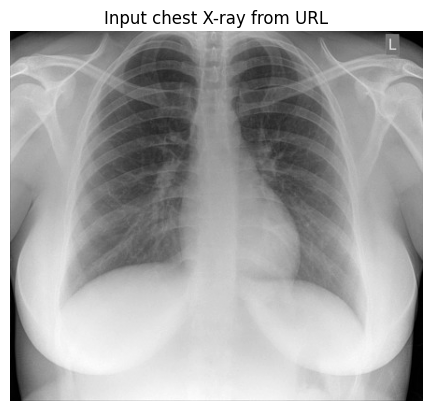


Top predicted labels:
No Finding            0.703
Infiltration          0.413
Nodule                0.333
Pneumothorax          0.302
Consolidation         0.248
Effusion              0.232
Mass                  0.216
Atelectasis           0.213
Pleural_Thickening    0.208
Fibrosis              0.157


In [ ]:
test_url = "https://prod-images-static.radiopaedia.org/images/10136416/502185e27fd4aadd6f1bcc65dd5738d4ed8da4aaec6e901cf5d07fc62768cdf3_gallery.jpeg"
preds = predict_xray_from_url(test_url, top_k=10)


Downloading: https://prod-images-static.radiopaedia.org/images/1420387/6f63736ff837ff7c5a736b35aba6ab_big_gallery.jpeg


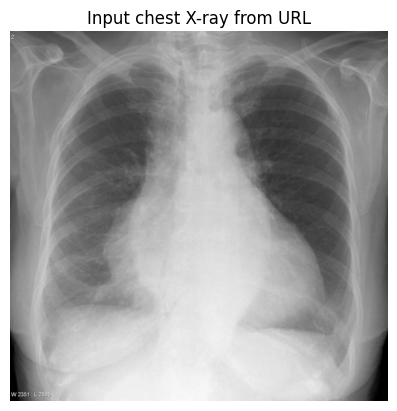


Top predicted labels:
Cardiomegaly          0.861
Effusion              0.709
Pleural_Thickening    0.626
Atelectasis           0.617
Fibrosis              0.554
Emphysema             0.520
Infiltration          0.508
Pneumothorax          0.487
Consolidation         0.469
Mass                  0.442


In [ ]:
test_url = "https://prod-images-static.radiopaedia.org/images/1420387/6f63736ff837ff7c5a736b35aba6ab_big_gallery.jpeg"
preds = predict_xray_from_url(test_url, top_k=10)